# RQ 1 (Frequency)

> How often does unsafe code appear explicitly in Rust crates?

## Setup

In [1]:
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 57.5 MB/s eta 0:00:00a 0:00:01


In [2]:
# import libraries
import itertools
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree

import utils
import top_crates
from whitelists import *
from drawing import *

# Configure pyplot: enlarge plots 
plt.rcParams['figure.figsize'] = [15, 8]
# Configure pandas: show all columns when printing a dataframe
pd.set_option('display.max_columns', None)
# Configure pandas: show more rows when printing a dataframe
pd.set_option('display.min_rows', 20)

In [3]:
import importlib
importlib.reload(utils)

<module 'utils' from '/home/jovyan/reports/utils.py'>

In [4]:
# Load tables
selected_builds = utils.load_selected_builds()
unsafe_blocks = utils.load_unsafe_blocks()
traits = utils.load_selected_traits()
traits_impls = utils.load_selected_impl_definitions()
function_definitions = utils.load_selected_function_definitions()
thir_blocks = utils.load_thir_blocks()

In [5]:
# Validation
# assert len(selected_builds) > 20000
assert selected_builds.build.is_unique

In [8]:
# Preprocessing
crates = pd.DataFrame({
    "crate": selected_builds.crate,
    "crate_hash": selected_builds.crate_hash,
    "package": selected_builds.package.map(lambda x: str(x).lower().replace("-", "_")),
})
user_written_unsafe_blocks = unsafe_blocks[unsafe_blocks.check_mode == "UnsafeBlockUserProvided"]
unsafe_function_definitions = function_definitions[function_definitions.unsafety == "Unsafe"]
unsafe_traits = traits[traits.unsafety == "Unsafe"]
unsafe_traits_impls = traits_impls[traits_impls.unsafety == "Unsafe"]
unsafe_thir_blocks = thir_blocks[thir_blocks.safety == "ExplicitUnsafe"]

# Validation
# assert len(user_written_unsafe_blocks) > 0

## Query 1

> Table 1 shows in both absolute and relative numbers how many crates contain unsafe code, and which unsafe features they use (our first query)

#### Results from the paper for comparison (Table 1)

| Unsafe Feature| #crates      |    %  |
| ------------- |--------------|-------|
| None          | 24,360       |  76.4 |
| Any           | 7,507        |  23.6 |
| Blocks        | 6,414        |  20.1 |
| Function Declarations| 4,287        |  13.5 |
| Trait Implementations| 1,591        |  5.0 |
| Trait Declarations| 280        |  0.9 |

Number of crates: 10
has_no_unsafe             6
has_unsafe_functions      4
has_unsafe_thir_blocks    4
has_unsafe                4
has_unsafe_blocks         1
has_unsafe_traits         0
has_unsafe_trait_impls    0
dtype: int64
has_no_unsafe             60.0
has_unsafe_functions      40.0
has_unsafe_thir_blocks    40.0
has_unsafe                40.0
has_unsafe_blocks         10.0
has_unsafe_traits          0.0
has_unsafe_trait_impls     0.0
dtype: float64


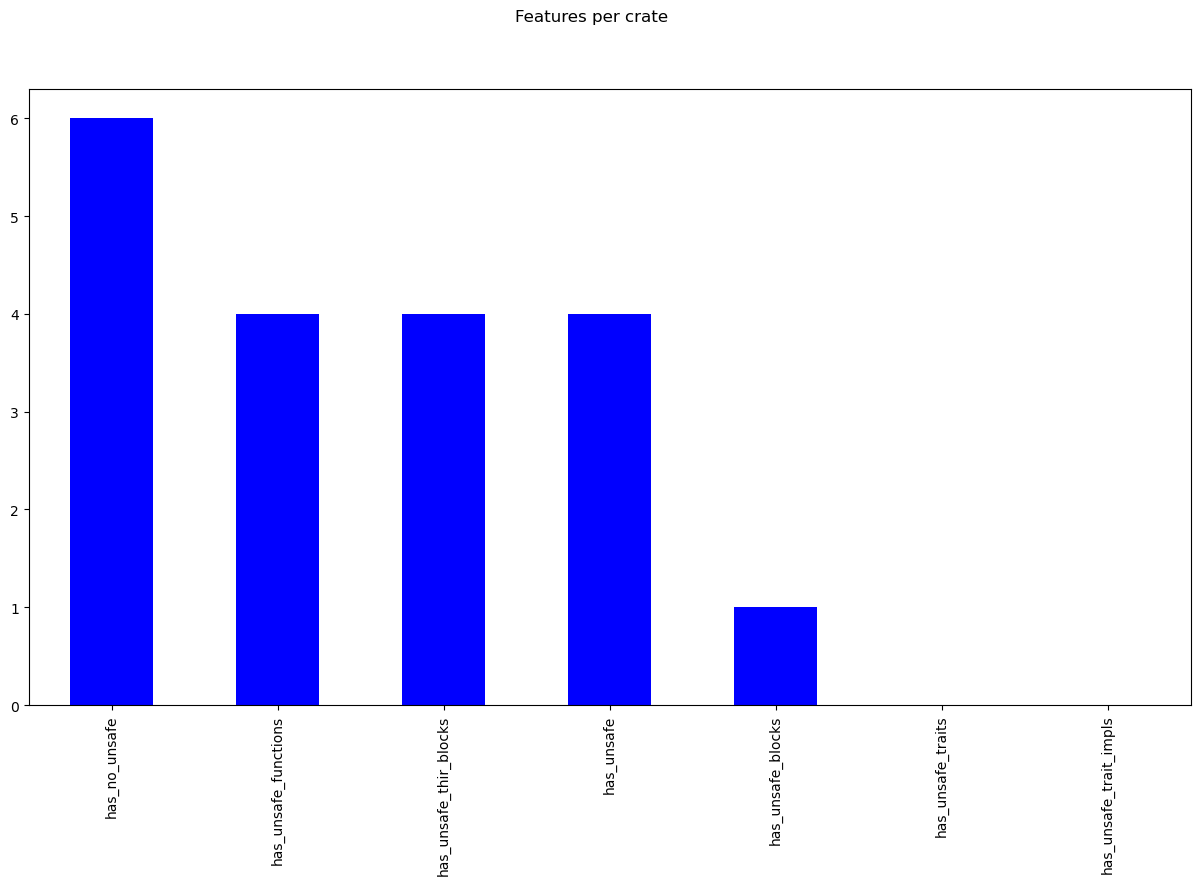

In [10]:
join_key = "crate_hash"
crates["has_unsafe_blocks"] = crates[join_key].isin(set(user_written_unsafe_blocks[join_key].unique()))
crates["has_unsafe_functions"] = crates[join_key].isin(set(unsafe_function_definitions[join_key].unique()))
crates["has_unsafe_traits"] = crates[join_key].isin(set(unsafe_traits[join_key].unique()))
crates["has_unsafe_trait_impls"] = crates[join_key].isin(set(unsafe_traits_impls[join_key].unique()))
crates["has_unsafe_thir_blocks"] = crates[join_key].isin(set(unsafe_thir_blocks[join_key].unique()))

feature_names = [
    "has_unsafe_blocks",
    "has_unsafe_functions",
    "has_unsafe_traits",
    "has_unsafe_trait_impls",
    "has_unsafe_thir_blocks",
]

crates["has_unsafe"] = functools.reduce(lambda x, y: x | y, [crates[f] for f in feature_names])
feature_names.append("has_unsafe")

crates["has_no_unsafe"] = ~crates["has_unsafe"]
feature_names.append("has_no_unsafe")

print("Number of crates: {}".format(len(crates)))

feature_freq = crates[feature_names].apply(sum).sort_values(ascending=False)
feature_freq.plot.bar(subplots=True, color="blue", title="Features per crate")
print(feature_freq)
print(feature_freq / len(crates) * 100)

## Query 2

> while Fig. 2 shows the relative amount of statements in unsafe blocks and functions in both all crates and, for readability, crates that contain at least one unsafe statement (our second query).

#### Results from the paper for comparison (Fig. 2)

![Fig. 2](pics/unsafe_proportion.png)


In [ ]:
# Load tables
selected_function_sizes = utils.load_selected_function_sizes()
selected_build_sizes = utils.load_selected_build_sizes()

In [ ]:
assert len(selected_build_sizes.query('statement_count == 0')) == 0

In [ ]:
crates_with_unsafe_statements_count = len(selected_build_sizes.query('user_unsafe_statement_count > 0'))
print("The number of crates with at least one user written unsafe MIR statement:",
      crates_with_unsafe_statements_count)
print("Percentage:", 100 * crates_with_unsafe_statements_count / len(crates))
selected_build_sizes["ratio"] = selected_build_sizes.apply(
    lambda row: 100 * row['user_unsafe_statement_count']/row['statement_count'], axis=1)
build_sizes_with_unsafe = selected_build_sizes.query('user_unsafe_statement_count > 0')

In [ ]:
selected_builds = utils.load_selected_builds()
unsafe_selected_build_hashes = set(selected_build_sizes['build_crate_hash'])
selected_build_hashes = set(selected_builds['crate_hash'])
assert unsafe_selected_build_hashes.issubset(selected_build_hashes)
safe_selected_build_hashes = selected_build_hashes - unsafe_selected_build_hashes
safe_selected_build_sizes = []
for (_, build) in selected_builds.iterrows():
    if build['crate_hash'] in unsafe_selected_build_hashes:
        continue
    safe_selected_build_sizes.append({
        'package_name': build['package'],
        'package_version': build['version'],
        'crate_name': build['crate'],
        'build_crate_hash': build['crate_hash'],
        'edition': build['edition'],
        'statement_count': 1,
        'unsafe_statement_count': 0,
        'user_unsafe_statement_count': 0,
        'ratio': 0.0,
    })
all_selected_build_sizes = selected_build_sizes.append(safe_selected_build_sizes)
assert len(all_selected_build_sizes) == len(selected_build_sizes) + len(safe_selected_build_sizes)
assert len(selected_builds) == len(all_selected_build_sizes)

In [ ]:
print('Proportion of all crates for which unsafe statement ratio is <= 10%:',
      100 * len(all_selected_build_sizes.query('ratio <= 10'))/len(all_selected_build_sizes))
print('Proportion of crates with at least one unsafe statement for which unsafe statement ratio is <= 20%:',
      100 * len(build_sizes_with_unsafe.query('ratio <= 20'))/len(build_sizes_with_unsafe))

In [ ]:
ax = all_selected_build_sizes.ratio.plot.hist(
 cumulative=True,
 density=1,
 bins=len(build_sizes_with_unsafe),
 xlim=(0, 100),
 ylim=(0, 1),
 histtype="step",
 linewidth=4,
 fontsize=26,
)
ax2 = build_sizes_with_unsafe.ratio.plot.hist(
 cumulative=True,
 density=1,
 bins=len(build_sizes_with_unsafe),
 xlim=(0, 100),
 ylim=(0, 1),
 histtype="step",
 linewidth=4,
 fontsize=26,
)
ax.title.set_size(20)
ax.set_xlabel("Proportion of unsafe statements in a crate", fontsize=32)
ax.set_ylabel("Percentage of crates", fontsize=32)
ax.set_axisbelow(True)
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
ax.set_xticklabels(['{:,.0%}'.format(x/100) for x in ax.get_xticks()])
ax.set_xticks(range(0, 100, 10), minor=True)
ax.set_xticks(range(0, 100, 20))
ax.grid(True, linestyle='dotted')
plt.show()